## Custom Modelling

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import random

In [2]:
# Read data from stored csv files
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')
Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

1) Split your whole data into train and test(80-20)



2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).



From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).



Now create 'k' models and train each of these models with each of these k samples.



3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.



4) Now, using these k predictions, create a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.



5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.



I hope you got it. For base models, you can consider any Tree-based model; you can take the Decision Tree itself. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.

In [3]:
Final_Dataset_Provider_Train.head(2)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,Claim_Period,ExtraClaimDays,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,...,PerProviderClmDiagnosisCode_4_count_ClaimID,PerProviderClmDiagnosisCode_5_count_ClaimID,PerProviderClmDiagnosisCode_6_count_ClaimID,PerProviderDiagnosisGroupCode_count_ClaimID,Gender_0,Gender_1,Race_1,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,61,0.0,5,8,300,...,297,297,297,405,16.0,9.0,21.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,382.0,617,0.0,62,29,1560,...,3046,4452,5556,4972,78.0,54.0,107.0,24.0,0.0,1.0


In [4]:
Final_Dataset_Provider_Train.shape, Final_Dataset_Provider_Test.shape

((5410, 247), (1353, 246))

#### Split your whole data into train and test(80-20)

In [5]:
# Split your whole data into train and test(80-20)
from sklearn.model_selection import train_test_split
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 247), (1082, 247))

In [6]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 245), (4328,))

In [7]:
# prepare test data
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [8]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]
x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']
x_validation.shape, y_validation.shape

((1082, 245), (1082,))

In [9]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)
x_test_std = standard_scaler.transform(x_test)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [10]:
x_val.shape, y_val.shape

((1082, 245), (1082,))

#### Now, in the 80% train set, split the train set into D1 and D2.(50-50)

In [11]:
# Now, in the 80% train set, split the train set into D1 and D2.(50-50)
x_d1, x_d2, y_d1, y_d2 = train_test_split(x_tr, y_tr, test_size=0.5,random_state=42,stratify=y_tr)
x_d1.shape, x_d2.shape, y_d1.shape, y_d2.shape

((2164, 245), (2164, 245), (2164,), (2164,))

In [12]:
from sklearn.metrics import roc_curve, auc , f1_score
import matplotlib.pyplot as plt
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [13]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    # plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [14]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Define a function to randomly sample data from dataset

In [15]:
# define a function to randomly sample data from dataset
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
import numpy as np
def row_col_sampling(x, y):
    total_row_count = x.shape[0]
    total_col_count = x.shape[1]
    # in sampled data i want to keep minimum 40% to maximum 60% number of rows
    sampled_row_count_min = round(total_row_count * 0.4)
    sampled_row_count_max = round(total_row_count * 0.6)
    # in a single dataset the rows should be unique, so setting "replace=False"
    sampled_row_indices = np.random.choice(total_row_count, np.random.randint(sampled_row_count_min,
                                                                              sampled_row_count_max),replace=False)
    sampled_row_indices = np.sort(sampled_row_indices)
    
    sampled_col_count_min = round(total_col_count * 0.4)
    sampled_col_count_max = round(total_col_count * 0.6)
    sampled_col_indices = np.random.choice(total_col_count, np.random.randint(sampled_col_count_min,
                                                                              sampled_col_count_max),replace=False)
    sampled_col_indices = np.sort(sampled_col_indices)
    # now select the sampled rows and columns from the input data
    
    #print(len(sampled_row_indices), len(sampled_col_indices))
    x_sampled = x[sampled_row_indices[:,None], sampled_col_indices]
    y_sampled = y[sampled_row_indices]
    #print(x_sampled.shape)
    
    return x_sampled, y_sampled, sampled_row_indices, sampled_col_indices

#### Function to create k sampled dataset

In [16]:
def create_k_dataset(x_tr, x_te, y_tr, y_te, k):
    x_tr_list = []
    y_tr_list = []
    x_te_list = []
    # y_te_list = []
    sampled_col_indices_list = []
    for i in range(k):
        x_sampled, y_sampled, sampled_row_indices, sampled_col_indices = row_col_sampling(x_tr, y_tr)
        x_tr_list.append(x_sampled)
        y_tr_list.append(y_sampled)
        x_te_list.append(x_te[:,sampled_col_indices])
        # y_te_list.append(y_te)
        sampled_col_indices_list.append(sampled_col_indices)
    return x_tr_list, y_tr_list, x_te_list, y_te, sampled_col_indices_list

## Base Learner - Combination of different models

In [17]:
# define a function to train base models
def train_model(x, y):
    
    model_count = 9
    # pick a model randomly and train it
    m = random.randint(1, model_count)
    if m == 1:
        model = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50, min_samples_split = 100)
        model = model.fit(x, y)
    elif m == 2:
        model = LogisticRegression(C=0.001,penalty="l2")
        model = model.fit(x, y)
    elif m == 3:
        model = svm.SVC(kernel='linear')
        model = CalibratedClassifierCV(model)
        model = model.fit(x, y)
    elif m == 4:
        model = svm.SVC(kernel='rbf')
        model = CalibratedClassifierCV(model)
        model = model.fit(x, y)
    elif m == 5:
        model = svm.SVC(kernel='poly')
        model = CalibratedClassifierCV(model)
        model = model.fit(x, y)
    elif m == 6:
        model = svm.SVC(kernel='sigmoid')
        model = CalibratedClassifierCV(model)
        model = model.fit(x, y)
    elif m == 7:
        model = XGBClassifier(learning_rate=0.1, max_delta_step=0, max_depth=10)
        model = model.fit(x, y)
    elif m == 8:
        model = GaussianNB()
        model = model.fit(x, y)
    else:
        model = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=10, random_state=42)
        model = model.fit(x, y)
        
    return(model)

In [18]:
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    # take a empty list to store k models
    model_list = []
    for i in range(k):
        # train using train_model function and store in a list
        trained_model = train_model(x_tr_list[i], y_tr_list[i])
        model_list.append(trained_model)
    
    base_model_prediction_list = []
    for j in range(k):
        # predict and store in a list
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)

    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()

    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9319445706038494
Test AUC =  0.9516557160303186


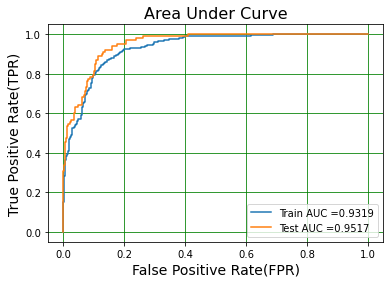

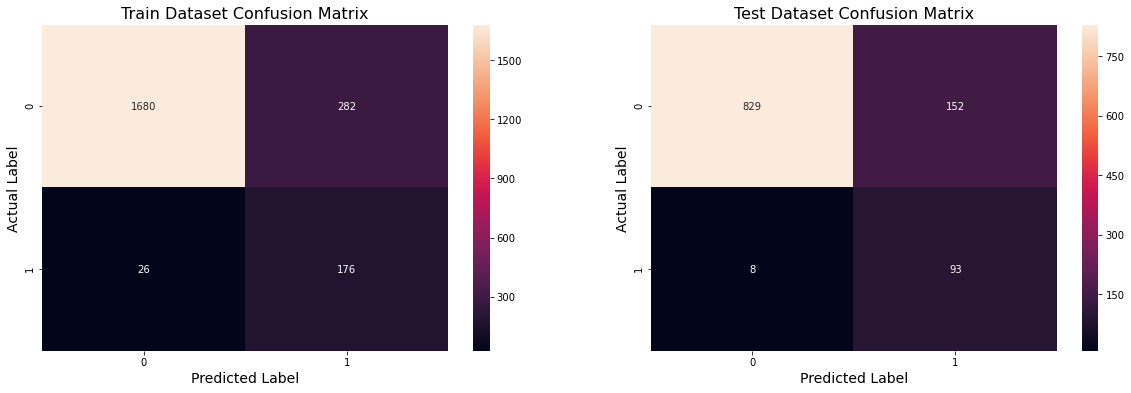

Best Threshold = 0.0919
Model AUC is : 0.9517
Model F1 Score is : 0.5376
						Number of base learners =  20
Train AUC =  0.9348941774911436
Test AUC =  0.9479920469111132


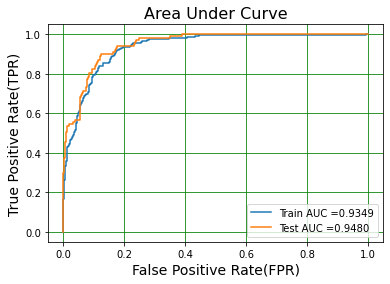

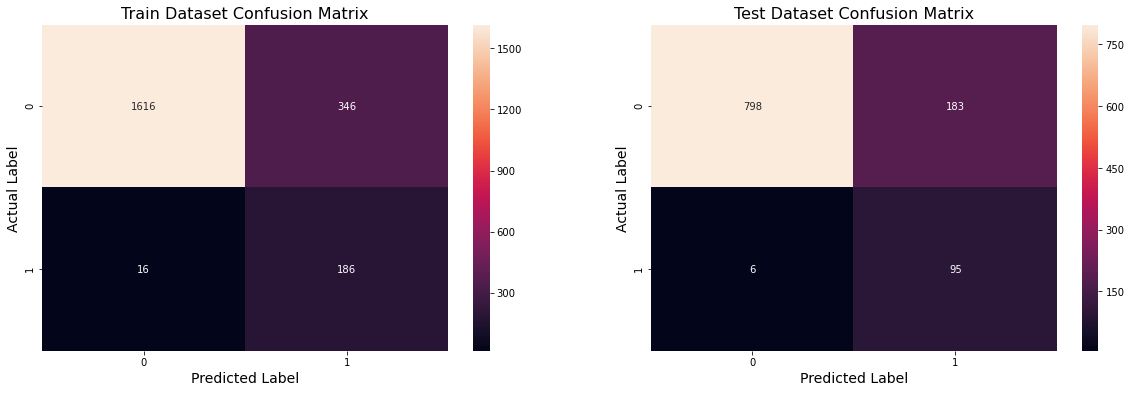

Best Threshold = 0.0953
Model AUC is : 0.9480
Model F1 Score is : 0.5013
						Number of base learners =  50
Train AUC =  0.9368370323270859
Test AUC =  0.9527053622793472


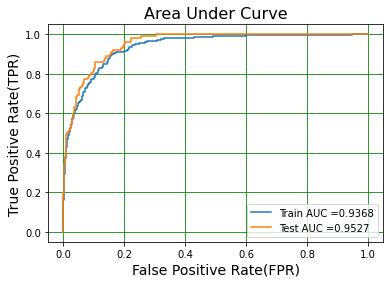

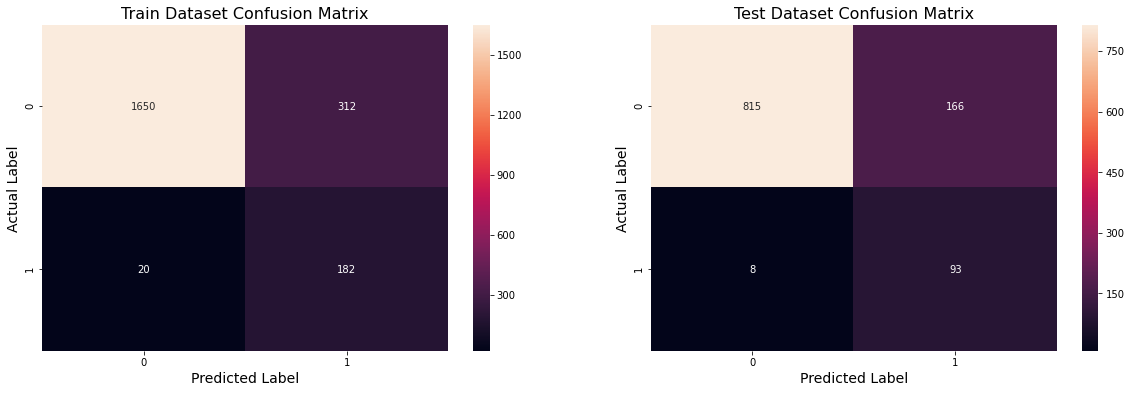

Best Threshold = 0.0934
Model AUC is : 0.9527
Model F1 Score is : 0.5167
						Number of base learners =  80
Train AUC =  0.9381970307122456
Test AUC =  0.9519887768593374


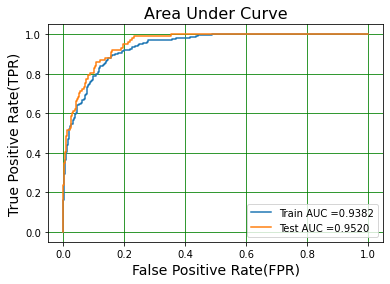

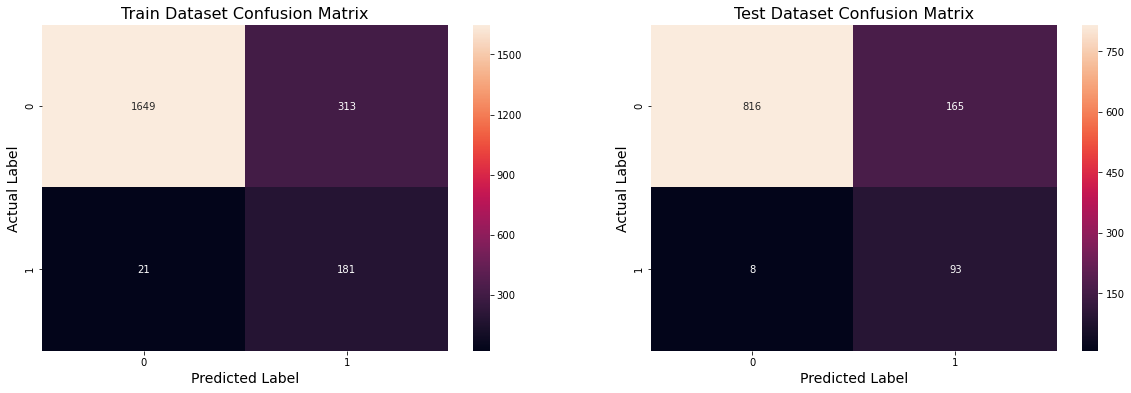

Best Threshold = 0.0867
Model AUC is : 0.9520
Model F1 Score is : 0.5181
						Number of base learners =  100
Train AUC =  0.9402559522007248
Test AUC =  0.9535531534804856


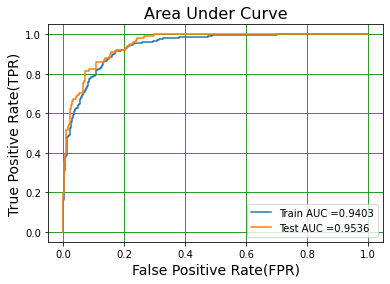

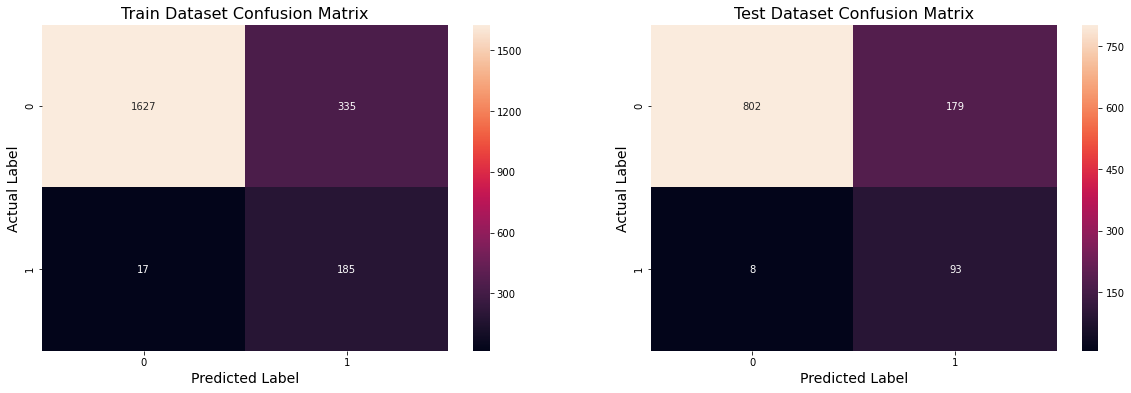

Best Threshold = 0.0814
Model AUC is : 0.9536
Model F1 Score is : 0.4987
						Number of base learners =  150
Train AUC =  0.9383332828695714
Test AUC =  0.9512015421725659


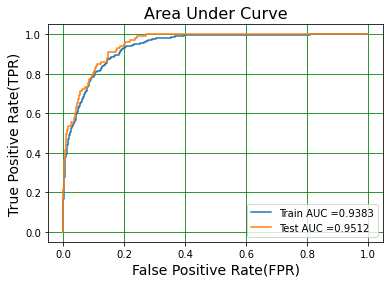

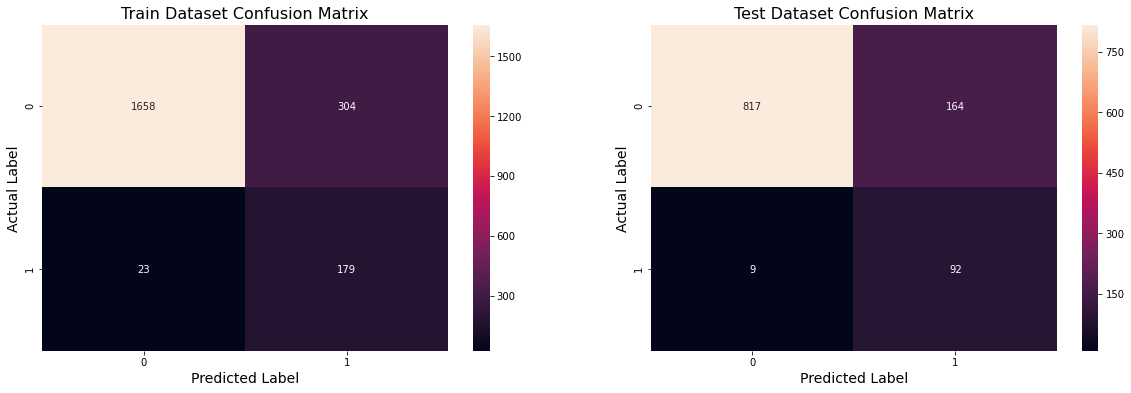

Best Threshold = 0.0781
Model AUC is : 0.9512
Model F1 Score is : 0.5154
						Number of base learners =  175
Train AUC =  0.9373240076301208
Test AUC =  0.9529072173272374


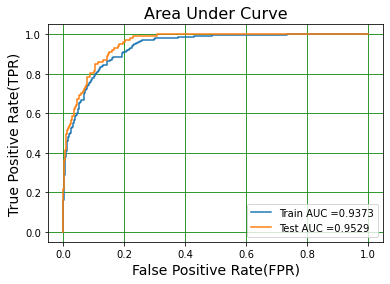

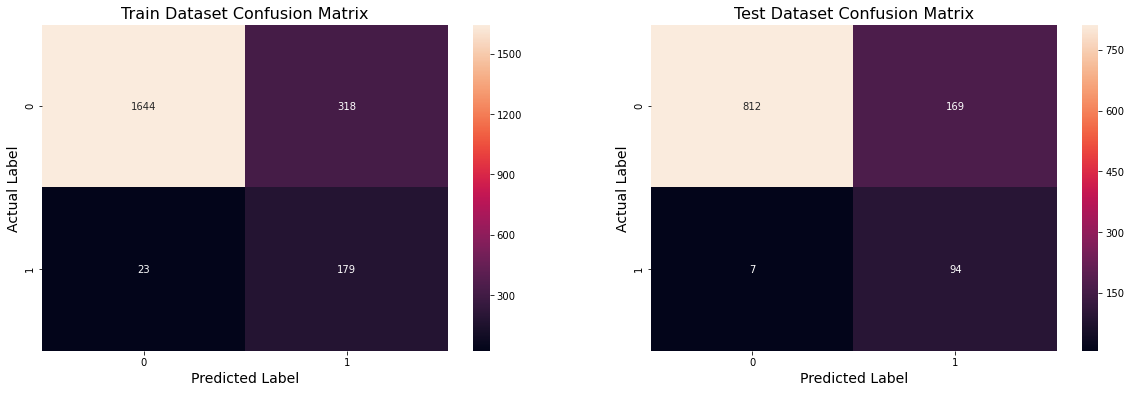

Best Threshold = 0.0741
Model AUC is : 0.9529
Model F1 Score is : 0.5165
						Number of base learners =  200
Train AUC =  0.9388152117964089
Test AUC =  0.9526548985173746


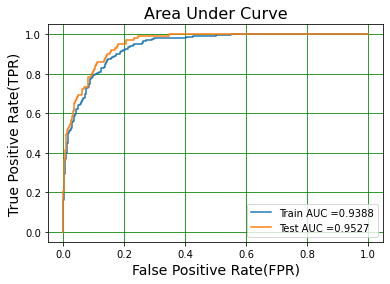

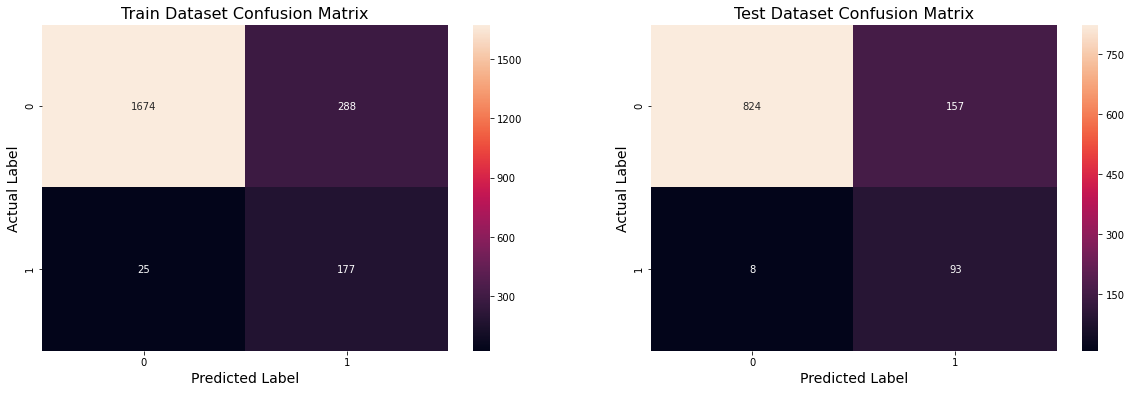

Best Threshold = 0.0786
Model AUC is : 0.9527
Model F1 Score is : 0.5299


In [19]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Meta Model - LogisticRegression

In [20]:
# create 100 sampled dataset
k = 100
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [21]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [22]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93660073        nan 0.93827562        nan 0.93900289
        nan 0.93653742        nan 0.93185722        nan 0.91892017
        nan 0.91577498]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.93767936        nan 0.939901          nan 0.94214391
        nan 0.94656141        nan 0.95186138        nan 0.95498694
        nan 0.95536184]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [23]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9390028871351184


Train AUC =  0.9420272302459602
Test AUC =  0.9579334080197011


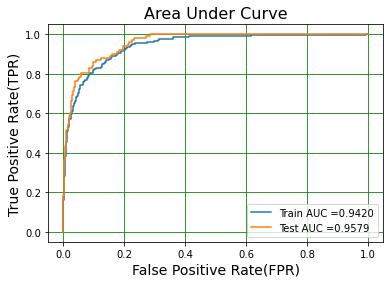

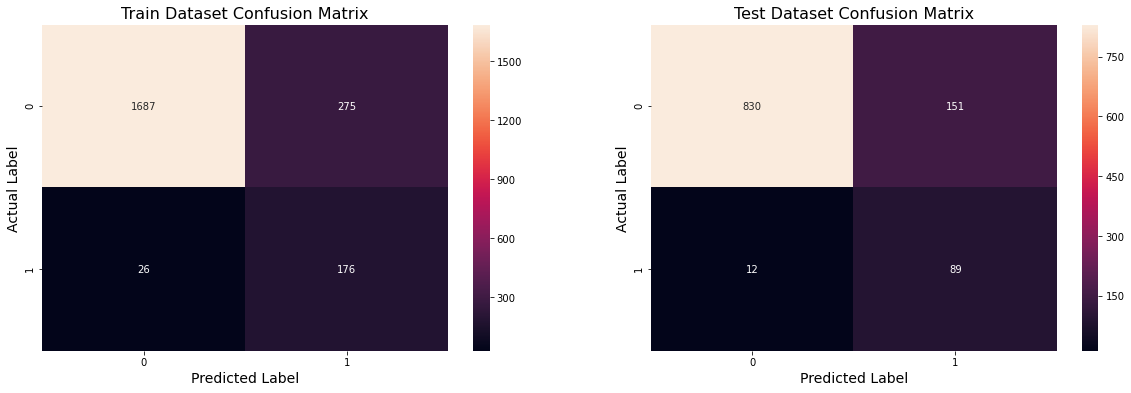

Best Threshold = 0.0710
Model AUC is : 0.9579
Model F1 Score is : 0.5220


In [24]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [40]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Meta Model", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.9579", "0.5220"])
print(table)

+---------------------+-------+----------+
|     Meta Model      |  AUC  | F1 Score |
+---------------------+-------+----------+
| Logistic Regression | 0.958 |  0.522   |
+---------------------+-------+----------+


C:\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
C:\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Meta Model - Decision Tree

In [25]:
# find best parameters for Decision Tree
decisiontree = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [26]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 250}
roc_auc_score : 0.9167345323905023


Train AUC =  0.9498932691434281
Test AUC =  0.9396150624236737


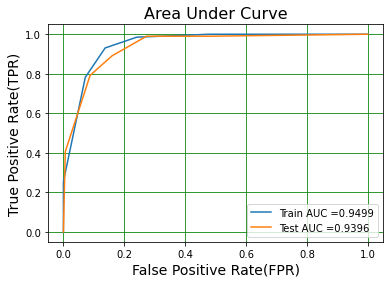

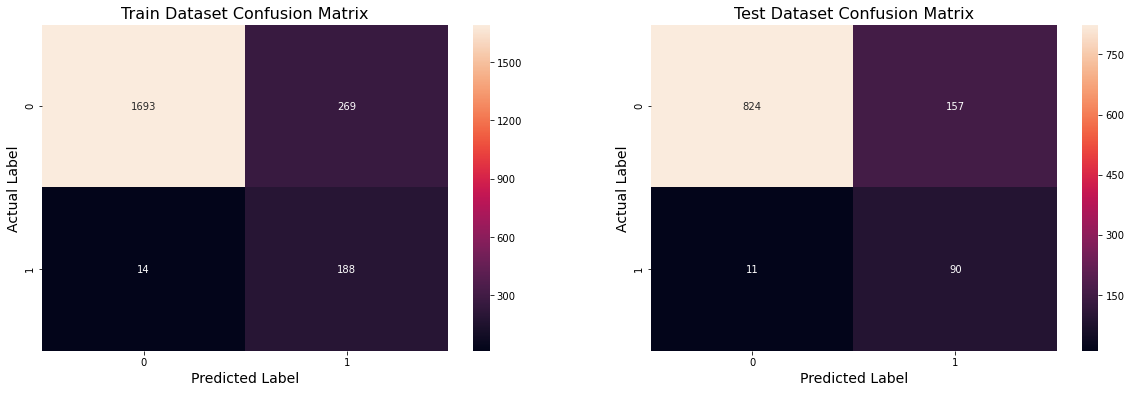

Best Threshold = 0.1899
Model AUC is : 0.9396
Model F1 Score is : 0.5172


In [27]:
decision_tree = DecisionTreeClassifier(criterion = 'entropy' ,max_depth = 5, min_samples_split = 250)
decision_tree.fit(x_tr_meta_model, y_te_d2)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [41]:
table.append_row(["Decision Tree", "0.9396", "0.5172"])
print(table)

+---------------------+-------+----------+
|     Meta Model      |  AUC  | F1 Score |
+---------------------+-------+----------+
| Logistic Regression | 0.958 |  0.522   |
+---------------------+-------+----------+
|    Decision Tree    | 0.94  |  0.517   |
+---------------------+-------+----------+


C:\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Meta Model - Support Vector Classifier

In [28]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.9309622         nan 0.92487762]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.95123131        nan 0.95252092]
  category=UserWarning


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [29]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.930962196040211


In [30]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.9487464801526024
Test AUC =  0.9562277328650296


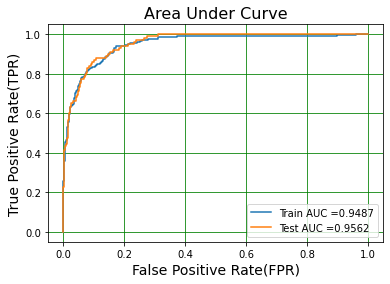

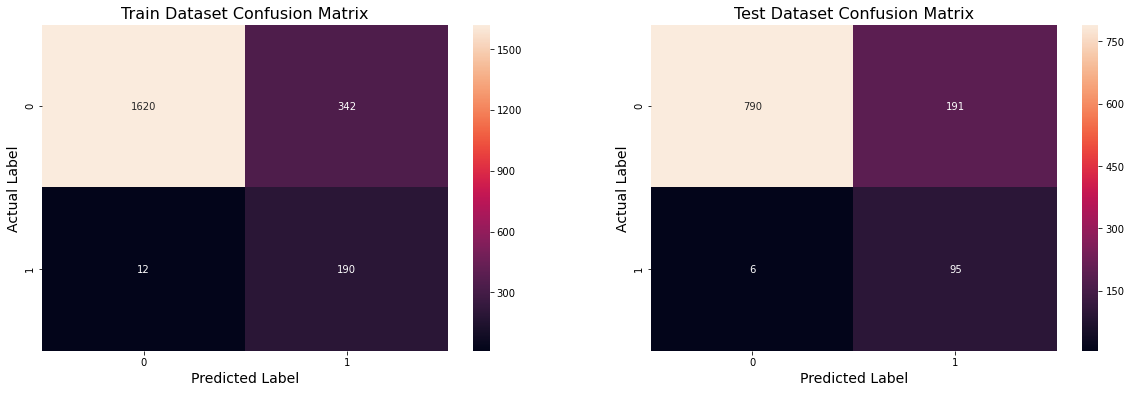

Best Threshold = 0.0581
Model AUC is : 0.9562
Model F1 Score is : 0.4910


In [31]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [42]:
table.append_row(["SVC", "0.9562", "0.4910"])
print(table)

+---------------------+-------+----------+
|     Meta Model      |  AUC  | F1 Score |
+---------------------+-------+----------+
| Logistic Regression | 0.958 |  0.522   |
+---------------------+-------+----------+
|    Decision Tree    | 0.94  |  0.517   |
+---------------------+-------+----------+
|         SVC         | 0.956 |  0.491   |
+---------------------+-------+----------+


C:\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Meta Model - Random Forest

In [32]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [33]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 5}
roc_auc_score : 0.9428012382573584


In [38]:
random_forest = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

Train AUC =  0.9842906308979522
Test AUC =  0.9630807117408988


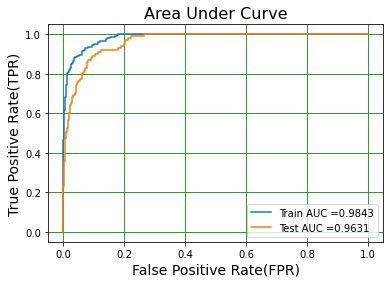

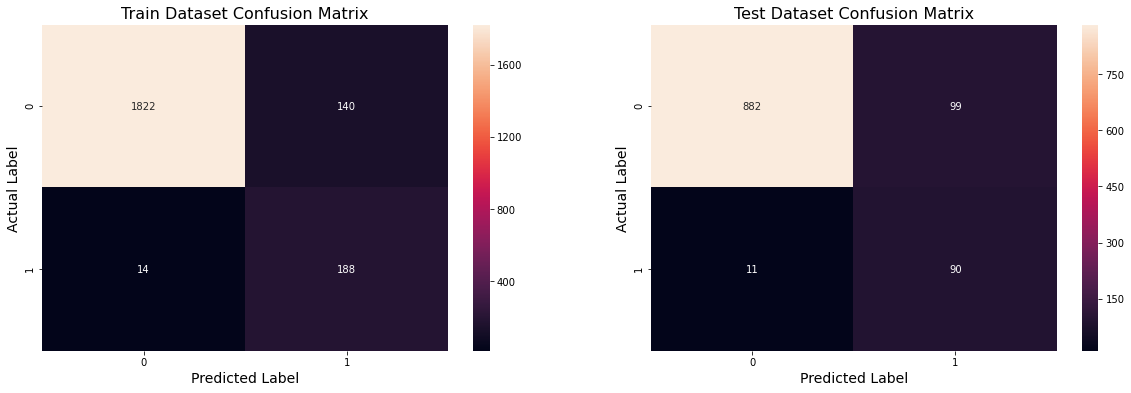

Best Threshold = 0.1797
Model AUC is : 0.9631
Model F1 Score is : 0.6207


In [39]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [43]:
table.append_row(["RF", "0.9631", "0.6207"])
print(table)

+---------------------+-------+----------+
|     Meta Model      |  AUC  | F1 Score |
+---------------------+-------+----------+
| Logistic Regression | 0.958 |  0.522   |
+---------------------+-------+----------+
|    Decision Tree    | 0.94  |  0.517   |
+---------------------+-------+----------+
|         SVC         | 0.956 |  0.491   |
+---------------------+-------+----------+
|         RF          | 0.963 |  0.621   |
+---------------------+-------+----------+


C:\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Conclusion:
Random Forest is working best as meta model using 50 different combination of base learners. So, I will train my model using Random Forest using best parameters and predict outputs.

### Train using Random Forest and predict output

In [44]:
random_forest = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

Train AUC =  0.9842906308979522
Test AUC =  0.9630807117408988


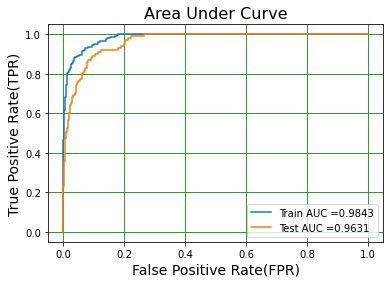

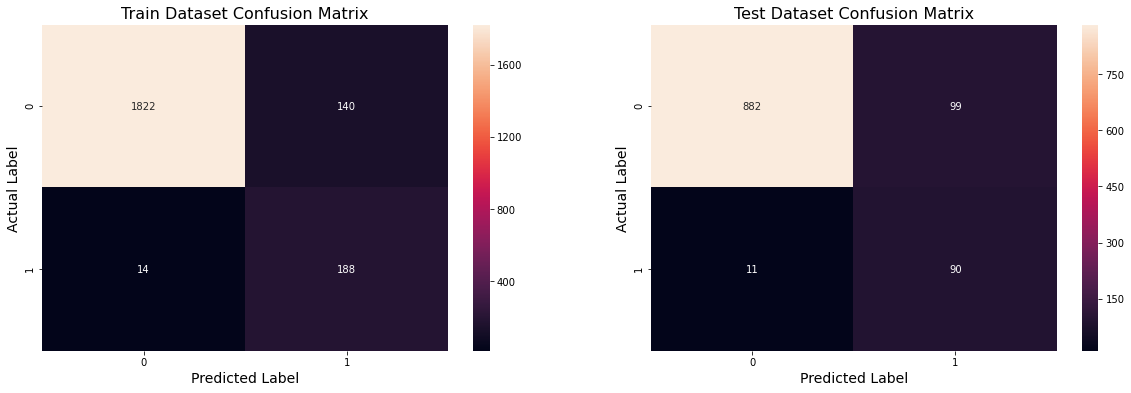

Best Threshold = 0.1797
Model AUC is : 0.9631
Model F1 Score is : 0.6207


In [45]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Add the predicted labels to the dataframe containing original label

In [46]:
y_val_pred = pred_prob(random_forest, x_val_meta_model)
y_val_prediction = predict_with_best_t(y_val_pred, best_t)
x_validation_provider_labels['Predicted_Label'] = y_val_prediction
x_validation_provider_labels = x_validation_provider_labels.reset_index(drop=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
x_validation_provider_labels.head(10)

,Provider,PotentialFraud,Predicted_Label
0,PRV52573,0,0
1,PRV52731,0,0
2,PRV53323,0,0
3,PRV53166,0,0
4,PRV56177,0,0
5,PRV52878,0,0
6,PRV54477,0,0
7,PRV51176,0,0
8,PRV56819,0,1
9,PRV52599,0,0


In [48]:
x_validation_provider_labels.tail(10)

,Provider,PotentialFraud,Predicted_Label
1072,PRV53752,0,0
1073,PRV53539,0,0
1074,PRV52417,0,0
1075,PRV56528,0,0
1076,PRV52340,1,1
1077,PRV53129,0,0
1078,PRV51209,0,0
1079,PRV55446,0,0
1080,PRV56346,0,0
1081,PRV56080,0,0
